# Fine tunning de la red MobileNetV2
Usaremos las read neuronal MobileNetV2 de Google y usando fine tunning ajustaremos su output para un problema de clasificacion binaria sobre gatos y perros.

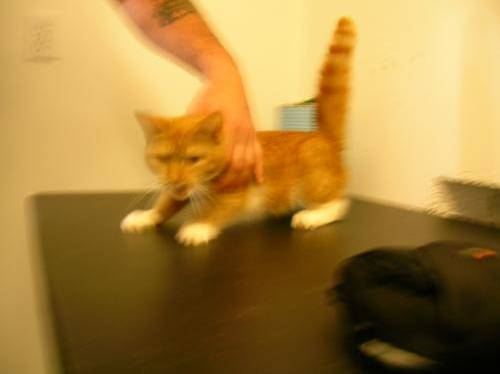   

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os

In [7]:
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Descargamos los datos de \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip  \
y los descomprimimos en la carpeta de nuestro directorio. Son un set de fotos de perros y gatos.

In [8]:
dataset_path = "./DATA/cats_and_dogs_filtered/"

In [9]:
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "validation")

## Setup del modelo

Tamaño de las imagenes

In [10]:
img_shape = (128, 128, 3)

Obtencion del modelo MobileNetV2

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

En caso de que se quiera checar la estructura de MobileNetV2.

In [9]:
# base_model.summary()

Congelamos el modelo

In [10]:
base_model.trainable = False

Definimos la cabecera del la red

In [11]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [13]:
global_average_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [14]:
prediction_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

Combinamos las caps creadas con MobileNetV2

In [15]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Definimos el optimizador y compilamos el modelo completo.

In [17]:
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, centered = False)

In [18]:
model.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])

## Generacion de los datos
Convertimos las imagenes muestras en informacion usable. Para empezar, el modelo acepta imagenes cuadradas del mismo tamaño por loq ue tenemos que re-escalar las imagenes para los casos de entrenamiento y validacion

In [19]:
data_gen_train = ImageDataGenerator(rescale=1/255)
data_gen_val = ImageDataGenerator(rescale=1/255)

Definimos un generador de datos para entrenar, leyendo las imagenes directamente del directorio en batches de 128 imagenes

In [20]:
trian_gen = data_gen_train.flow_from_directory(
    directory = train_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=128,
    shuffle=True,
    save_format='png'
)

Found 2000 images belonging to 2 classes.


In [21]:
val_gen = data_gen_val.flow_from_directory(
    directory = validation_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=128,
    shuffle=True,
    save_format='png'
)

Found 1000 images belonging to 2 classes.


## Entrenar el modelo

In [22]:
model.fit(trian_gen, epochs = 7, validation_data = val_gen)

Epoch 1/7
16/16 [==============================] - 114s 7s/step - loss: 0.6552 - accuracy: 0.6280 - val_loss: 0.6181 - val_accuracy: 0.6600
Epoch 2/7
16/16 [==============================] - 111s 7s/step - loss: 0.5537 - accuracy: 0.7275 - val_loss: 0.5360 - val_accuracy: 0.7420
Epoch 3/7
16/16 [==============================] - 105s 7s/step - loss: 0.4822 - accuracy: 0.7815 - val_loss: 0.4693 - val_accuracy: 0.7900
Epoch 4/7
16/16 [==============================] - 113s 7s/step - loss: 0.4226 - accuracy: 0.8290 - val_loss: 0.4136 - val_accuracy: 0.8380
Epoch 5/7
16/16 [==============================] - 109s 7s/step - loss: 0.3734 - accuracy: 0.8635 - val_loss: 0.3666 - val_accuracy: 0.8690
Epoch 6/7
16/16 [==============================] - 111s 7s/step - loss: 0.3310 - accuracy: 0.8885 - val_loss: 0.3265 - val_accuracy: 0.8850
Epoch 7/7
16/16 [==============================] - 91s 6s/step - loss: 0.2965 - accuracy: 0.9055 - val_loss: 0.2940 - val_accuracy: 0.9030


Evaluando el modelo con los datos de validacion, obteniendo una presicion de $\sim90\%$

In [23]:
model.evaluate(val_gen)

8/8 [==============================] - 20s 2s/step - loss: 0.2940 - accuracy: 0.9030


[0.2939620018005371, 0.902999997138977]

#### Visualizacion de algunas de las soluciones

Podemos ver unas cuantas de las fotos re escaladas y la prediccion del modelo.

In [24]:
predictions =  np.round(model.predict(val_gen[1][0]))
predictions_label = np.empty(dtype='str', shape=(0))

In [25]:
for a in range(0,128):
    if predictions[a][0] == 1.0:
        predictions_label = np.append(predictions_label, 'Dog')
    else:
        predictions_label = np.append(predictions_label, 'Cat')

Text(0.5, 1.0, 'Dog')

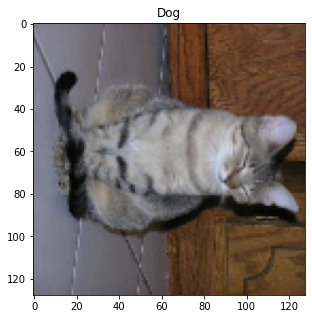

In [55]:
numero_de_imagen = 22
plt.figure(figsize=(5,5))
plt.imshow(val_gen[1][0][numero_de_imagen])
plt.title(str(predictions_label[numero_de_imagen]))

## Prueba de fine tunning

Haremos fine tunning en 34 de las 154 capas para evr si podemos mejorar la presicion del modelo

In [27]:
base_model.trainable = True

In [28]:
len(base_model.layers)

154

Iniciamos el fine tunning despues de las primeras 120 capas

In [29]:
fine_tune = 120

In [30]:
for layer in base_model.layers[:fine_tune]:
    layer.trainable = False

In [31]:
model.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.fit(trian_gen, epochs = 2, validation_data = val_gen)

Epoch 1/2
16/16 [==============================] - 105s 6s/step - loss: 0.1647 - accuracy: 0.9385 - val_loss: 0.1083 - val_accuracy: 0.9560
Epoch 2/2
16/16 [==============================] - 111s 7s/step - loss: 0.0274 - accuracy: 0.9985 - val_loss: 0.0981 - val_accuracy: 0.9620


In [33]:
model.evaluate(val_gen)

8/8 [==============================] - 32s 4s/step - loss: 0.0981 - accuracy: 0.9620


[0.0980713739991188, 0.9620000123977661]

Usando esto mejoramos la presicion considerablemente, obteniendo un valor de $\sim96\%$. Se podrian hacer mas pruebas con distintos grados de fine tunning para obtener incluso mejores resultados.